<a href="https://colab.research.google.com/github/s3965610/COSC2671-A2/blob/asif-recommender-system/Github-recommender-system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise
import json
from pandas import json_normalize
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from surprise import Dataset
from surprise import Reader
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic


In [3]:
# directory must be changed to local from google drive
with open("/content/drive/MyDrive/data/user_repos.json", "r") as read_file:
    user_repos = json.load(read_file)


##Save data in a dictionary

In [4]:
user_repos_dict = {}
data = []
for i in user_repos:
    temp = {}
    temp['Total Starred'] = user_repos[i]['data']['user']['starredRepositories']['totalCount']
    temp['StarredRepos'] = []
    row = []
    row.append(i)
    row.append(temp['Total Starred'] )
    for node in user_repos[i]['data']['user']['starredRepositories']['nodes']:
        temp['StarredRepos'].append(node['nameWithOwner'])

    row.append(temp['StarredRepos'])

    data.append(row)
    user_repos_dict[i] = temp


In [6]:
df = pd.DataFrame({'User': [],
                   'Repos': [],
                   'Rating': []})

In [7]:
for key, val in user_repos_dict.items():
    for repo in val['StarredRepos']:
        row = []
        df2 = pd.DataFrame({'User': [key],
                    'Repos': [repo],
                    'Rating': [1]})
        df = df.append(df2, ignore_index = True)

In [8]:
df.head(5)

,User,Repos,Rating
0,01885326842,novuhq/novu,1.0
1,0x00evil,atom/atom,1.0
2,0x00evil,greatfire/wiki,1.0
3,0x00evil,rails-sqlserver/activerecord-sqlserver-adapter,1.0
4,0x00evil,OpenRA/OpenRA,1.0


## Visualisation

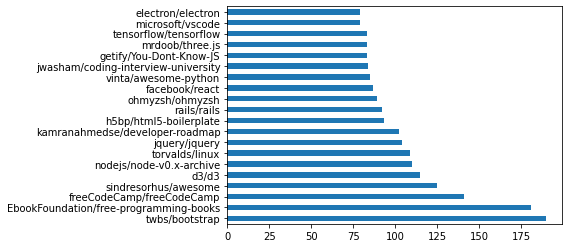

In [17]:
df['Repos'].value_counts()[:20].plot(kind='barh')

Some items are more popular than others

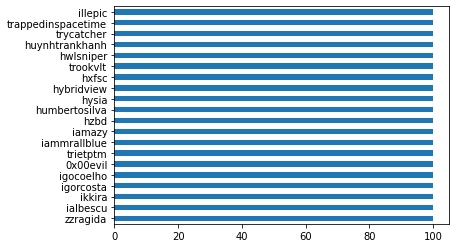

In [15]:
df['User'].value_counts()[:20].plot(kind='barh')

## Filter data
We take the repositories that has at least 20 ratings.
We take user that has given at least 50 ratings.

In [9]:
min_ratings = 20 
filter_repos = df['Repos'].value_counts() > min_ratings
filter_repos = filter_repos[filter_repos].index.tolist()

min_user_ratings = 50
filter_users = df['User'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['Repos'].isin(filter_repos)) & (df['User'].isin(filter_users))]

## Model Evalutation

We evaluate 6 models based on 3 algorithms. An use RMSE as the evaluation metrics

In [11]:

reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df_new[['User', 'Repos', 'Rating']], reader)

In [18]:
from surprise.model_selection.validation import cross_validate
benchmark = []

for algorithm in [SVD(), SVDpp(),  NMF()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, return_train_measures=True, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

,test_rmse,train_rmse,fit_time,test_time
Algorithm,,,,
SVDpp,0.031614,0.024567,1.177204,0.087169
SVD,0.062449,0.047902,0.396250,0.021892
NMF,0.065110,0.059487,0.581481,0.021867


SVDpp performing the best with barely any overfitting and low RMSE.